Using Bayesian classification to classify between types of banknotes (with features that distribute normally)

import libraries

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load the wine dataset from https://sharon.srworkspace.com/ml/datasets/hw1/banknote_authentication.csv

In [16]:
url = "https://sharon.srworkspace.com/ml/datasets/hw1/banknote_authentication.csv"
df = pd.read_csv(url)
df = df.dropna()
print(df.shape)
df.head(3)

(600, 6)


,contrast,skew,curtosis,heat,cent_col,Class
0,2.446909,2.702995,0.832495,0.531505,-1.734316,0
1,0.870104,2.248493,-1.496408,1.383379,-1.216271,0
2,-1.930227,-2.708964,1.031232,-0.125341,0.683788,2


Making sure that the features are normaly distributed.

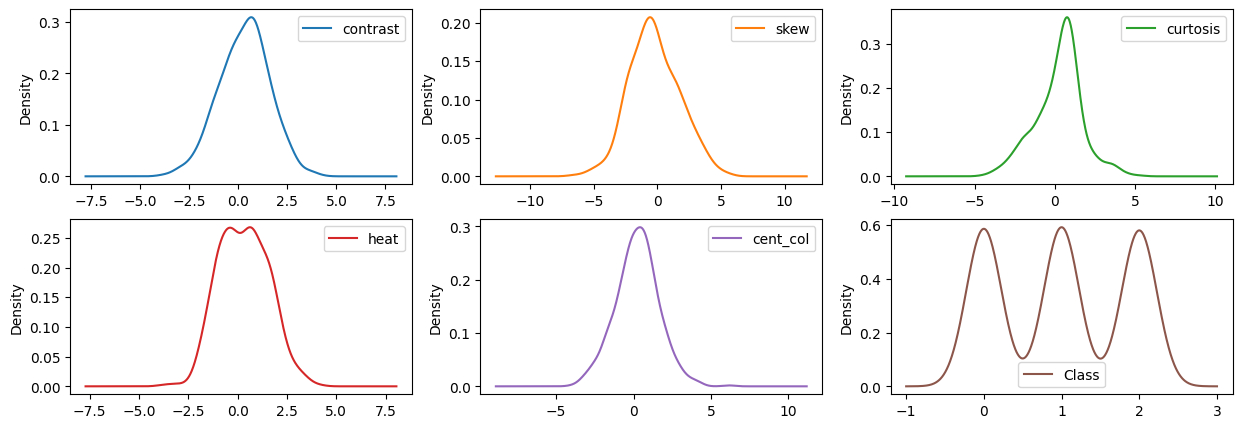

In [17]:
df.plot(kind='density', subplots=True, layout=(2,3), figsize=(15, 5), sharex=False)
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x = df.drop('Class', axis=1)
y = df['Class'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=33, stratify=y)

Classification predictions of gaussian bayes and naive gaussian bayes

In [19]:
def classify_point_gaussian_bayes(test_data):
  predicts = []

  zero_Class = x_train[y_train == 0]
  one_Class = x_train[y_train == 1]
  two_Class = x_train[y_train == 2]

  zero_mean = np.array(np.mean(zero_Class, axis=0))
  zero_mean = zero_mean.reshape(1, x_train.shape[1])
  one_mean = np.array(np.mean(one_Class, axis=0))
  one_mean = one_mean.reshape(1, x_train.shape[1])
  two_mean = np.array(np.mean(two_Class, axis=0))
  two_mean = two_mean.reshape(1, x_train.shape[1])


  zero_var = np.cov(zero_Class.T)
  one_var = np.cov(one_Class.T)
  two_var = np.cov(two_Class.T)
  zero_var_reg = zero_var + np.eye(zero_var.shape[0]) * 1e-8
  one_var_reg = one_var + np.eye(one_var.shape[0]) * 1e-8
  two_var_reg = two_var + np.eye(two_var.shape[0]) * 1e-8

  zero_count = zero_Class.shape[0]
  one_count = one_Class.shape[0]
  two_count = two_Class.shape[0]
  n = zero_count + one_count + two_count

  for i in range(test_data.shape[0]):
    current = test_data.iloc[i].values.reshape(1, test_data.shape[1])
   
    g_zero = -0.5 * (current - zero_mean).T * np.linalg.inv(zero_var_reg) * (current - zero_mean) 
    - 0.5 * np.log(np.linalg.det(zero_var_reg)) + np.log(zero_count / n)

    g_one = -0.5 * (current - one_mean).T * np.linalg.inv(one_var_reg) * (current - one_mean) 
    - 0.5 * np.log(np.linalg.det(one_var_reg)) + np.log(one_count / n)

    g_two = -0.5 * (current - two_mean).T * np.linalg.inv(two_var_reg) * (current - two_mean) 
    - 0.5 * np.log(np.linalg.det(two_var_reg)) + np.log(two_count / n)

    biggest = max(g_zero[0,0], g_one[0,0], g_two[0,0])
    if (biggest == g_zero[0,0]):
      predicts.append(0)
    elif (biggest == g_one[0,0]):
      predicts.append(1)
    else:
      predicts.append(2)

  return np.array(predicts)



# Assuming that the features are independent
def classify_point_gaussian_naive_bayes(test_data):
    predicts = []

    zero_Class = x_train[y_train == 0]
    one_Class = x_train[y_train == 1]
    two_Class = x_train[y_train == 2]
    
    zero_mean = np.array(np.mean(zero_Class, axis=0))
    one_mean = np.array(np.mean(one_Class, axis=0))
    two_mean = np.array(np.mean(two_Class, axis=0))

    zero_var = np.cov(zero_Class.T)
    one_var = np.cov(one_Class.T)
    two_var = np.cov(two_Class.T)

    zero_count = zero_Class.shape[0]
    one_count = one_Class.shape[0]
    two_count = two_Class.shape[0]
    n = zero_count + one_count + two_count

    for i in range(test_data.shape[0]):
        input = np.array(test_data)
        g_zero = np.log(zero_count / n)
        g_one = np.log(one_count / n)
        g_two = np.log(two_count / n)
        for j in range(test_data.shape[1]):
            g_zero += np.log((1 / np.sqrt(2 * np.pi * zero_var[j,j]))) - (1/2) * ((input[i,j] - zero_mean[j]) ** 2) / zero_var[j,j]
            g_one += np.log((1 / np.sqrt(2 * np.pi * one_var[j,j]))) - (1/2) * ((input[i,j] - one_mean[j]) ** 2) / one_var[j,j]
            g_two += np.log((1 / np.sqrt(2 * np.pi * two_var[j,j]))) - (1/2) * ((input[i,j] - two_mean[j]) ** 2) / two_var[j,j]

        predicts.append(np.argmax([g_zero, g_one, g_two]))

    return np.array(predicts)

Gaussian bayes vs. naive gaussian bayes (in accuracy)

In [20]:
# Reminder: success rate is the precentage of correctly classified data within the number of all data in the test set.

dict1 = {'GB': [], 'GNB': []}

accs = classify_point_gaussian_bayes(x_train)
dict1['GB'].append(100 * np.count_nonzero(accs == y_train) / len(y_train))

accs = classify_point_gaussian_bayes(x_test)
dict1['GB'].append(100 * np.count_nonzero(accs == y_test) / len(y_test))

accs = classify_point_gaussian_naive_bayes(x_train)
dict1['GNB'].append(100 * np.count_nonzero(accs == y_train) / len(y_train))

accs = classify_point_gaussian_naive_bayes(x_test)
dict1['GNB'].append(100 * np.count_nonzero(accs == y_test) / len(y_test))

df = pd.DataFrame(dict1, columns=['GB', 'GNB'], index=['train', 'test'])
print(df)

              GB        GNB
train  54.375000  85.000000
test   49.166667  83.333333


Idea for improvement:
remove the most highly correlated feature, cent_col.

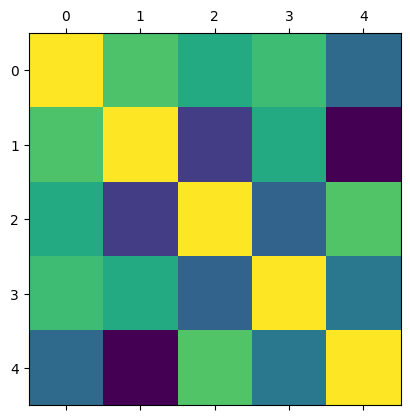

In [21]:
import matplotlib.pyplot as plt
plt.matshow(x.corr())
plt.show()

In [22]:
x_train = x_train.drop('cent_col', axis=1)
x_test = x_test.drop('cent_col', axis=1)

dict1 = {'GB': [], 'GNB': []}

accs = classify_point_gaussian_bayes(x_train)
dict1['GB'].append(100 * np.count_nonzero(accs == y_train) / len(y_train))

accs = classify_point_gaussian_bayes(x_test)
dict1['GB'].append(100 * np.count_nonzero(accs == y_test) / len(y_test))

accs = classify_point_gaussian_naive_bayes(x_train)
dict1['GNB'].append(100 * np.count_nonzero(accs == y_train) / len(y_train))

accs = classify_point_gaussian_naive_bayes(x_test)
dict1['GNB'].append(100 * np.count_nonzero(accs == y_test) / len(y_test))

df = pd.DataFrame(dict1, columns=['GB', 'GNB'], index=['train', 'test'])
print(df)

              GB        GNB
train  46.666667  84.583333
test   49.166667  86.666667


Some improvement in test accuracy of naive bayes ( :) )
Let's actually see the boundries the algorithm predicted.

In [23]:
# Essential scailing for the visualization

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

(8178, 4)


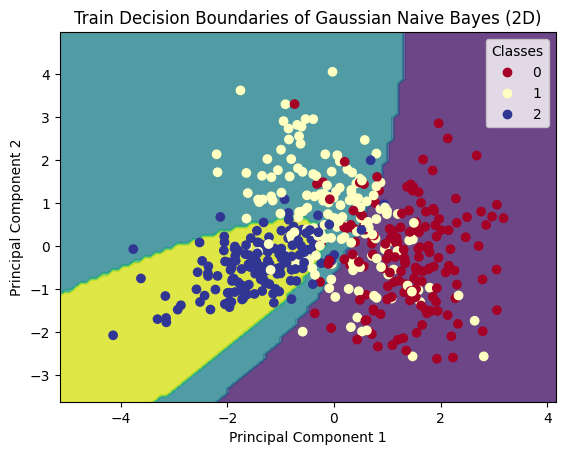

In [24]:
#@title Train Decision Boundaries of Gaussian Naive Bayes (2D)

from sklearn.decomposition import PCA
from tqdm import tqdm

# Reduce the dimensionality of the data to 2 using PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(x_train)

# Create a grid of points for visualization in the reduced 2D space
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Use the GNB model to predict class labels for the grid points in the original 13D space
grid_points = pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
print(grid_points.shape)
Z = classify_point_gaussian_naive_bayes(grid_points)
Z = Z.reshape(xx.shape)

# Plot the decision boundaries and the data points in the reduced 2D space
plt.contourf(xx, yy, Z, alpha=0.8)
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, cmap=plt.cm.RdYlBu)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a legend
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, title='Classes')

plt.title('Train Decision Boundaries of Gaussian Naive Bayes (2D)')
plt.show()

(7031, 4)


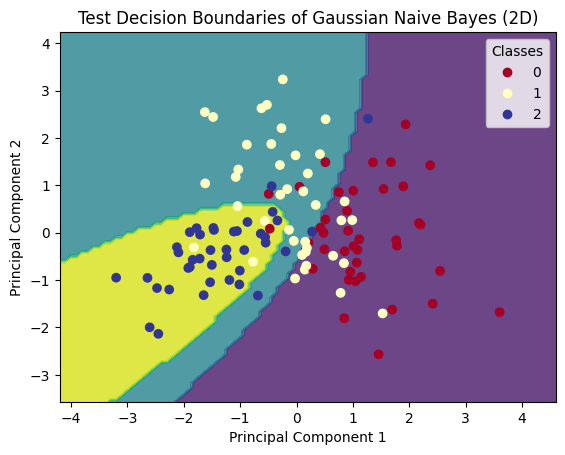

In [25]:
#@title Train Decision Boundaries of Gaussian Naive Bayes (2D)

from sklearn.decomposition import PCA
from tqdm import tqdm

# Reduce the dimensionality of the data to 2 using PCA
X_reduced = pca.transform(x_test)

# Create a grid of points for visualization in the reduced 2D space
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Use the GNB model to predict class labels for the grid points in the original 13D space
grid_points = pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
print(grid_points.shape)
Z = classify_point_gaussian_naive_bayes(grid_points)
Z = Z.reshape(xx.shape)

# Plot the decision boundaries and the data points in the reduced 2D space
plt.contourf(xx, yy, Z, alpha=0.8)
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_test, cmap=plt.cm.RdYlBu)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a legend
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, title='Classes')

plt.title('Test Decision Boundaries of Gaussian Naive Bayes (2D)')
plt.show()